In [120]:
import argparse, json, re
from Bio import SeqIO, Phylo
import pandas as pd
from string import digits
from itertools import groupby, count
from collections import defaultdict, Counter
from matplotlib import pyplot as plt


Text(0, 0.5, 'amount of mutations')

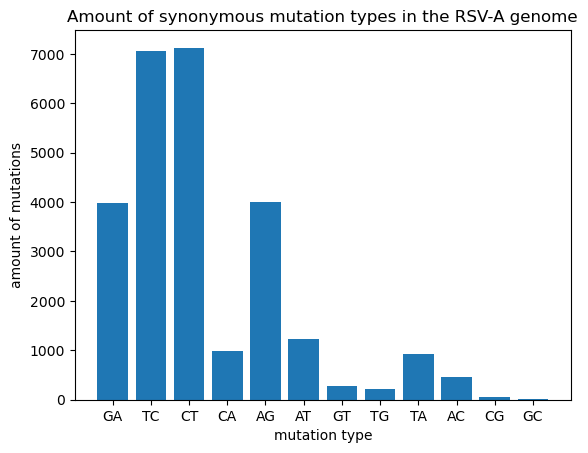

In [124]:
ref = SeqIO.read("data/areference.gbk", "genbank")
def CDS_finder(reference):
    """this function finds CDS location and not CDS location, and saves only those not located at the end of the function"""
    cds_ = dict()
    for feature in reference.features:
        if feature.type == 'CDS': 
            cds_[feature.qualifiers['gene'][0]] = (list(feature.location))

        if feature.type == 'source':everything = list(feature.location)

    #not_cds = list(set(everything)-set(cds_))
    #corrected_CDS = [x for x in cds_ if x<=14900]
    #corrected_not_CDS = [x for x in not_cds if x<=14900]
    return(cds_)
gene_cds = CDS_finder(ref)
#print(gene_cds)
def mutation_recursive(node, dictionary_=None, new_=None):
    """ this function returns a dictionary with node name as key and a list of mutations along that branch as the info"""
    gene_cds = CDS_finder(ref)
    

    if new_ is None:
        new_ = []
    if dictionary_ is None:
        dictionary_ = dict()

    if 'mutations' in node['branch_attrs']:
        aa_mutations = []
        new_ = []
        in_it = []
        if 'nuc' in node['branch_attrs']['mutations']:
            for gene, loc in gene_cds.items():
                if gene in node['branch_attrs']['mutations']:
                    for mut in node['branch_attrs']['mutations'][gene]:
                        aa_mutations.append(int(mut[1:-1])*3+loc[0])
            #print(len(aa_mutations))

            for mut in node['branch_attrs']['mutations']['nuc']:
                if '-' not in mut and '*' not in mut and 'N' not in mut:
                    if int(mut[1:-1]) not in aa_mutations and int(mut[1:-1])+2 not in aa_mutations and int(mut[1:-1])+1 not in aa_mutations:
                        new_.append(mut)
                    else: in_it.append(mut[1:-1])
             
    if 'name' in node:
            dictionary_[node['name']] = new_

    if 'children' in node:
        for child in node['children']:
           mutation_recursive(child, dictionary_, new_=None)
    
    return(dictionary_)
           
all_muts = []
mut_in_gene = defaultdict(list)
with open ("data/rsv_a_genome.json") as file_:
    f = json.load(file_)  
    mut_by_node = mutation_recursive(f['tree'])

    for node, muts in mut_by_node.items():
        for m in muts:
            all_muts.append(f'{m[0]}{m[-1]}')
#print(all_muts)
for_graph = Counter(all_muts)
plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A genome")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")




#gene_cds = CDS_finder(ref)
#for gene, cds in gene_cds.items():
    #for mut in all_muts:
        #if int(mut[1:-1]) in cds:
            #mut_in_gene[gene].append(mut)
         

In [68]:
from collections import Counter
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import argparse
from Bio import Phylo

def GenesAndCodons(aa_muts, nt_muts):
    codons=[]
    mutations_all = []
    all_genes =[] 
    with open(aa_muts) as a_muts:
        with open(nt_muts) as n_muts:
            dictofgenes=dict()
            aamuts = json.load(a_muts)
            ntmuts = json.load(n_muts)
            genes = ('F','G','M','M2','NS1','NS2','P','SH','N') #genes in RSV

            for gene in genes:
                for key, node in aamuts['annotations'].items():
                    if key == gene:
                        location_of_gene=[]
                        #mutation_in_gene =
                        location_of_gene = list(range(node['start'],node['end']+1)) #where each gene starts and ends
                dictofgenes[gene]=location_of_gene
        
            for k, n in aamuts['nodes'].items():
                for key, node in ntmuts['nodes'].items():
                    if k == key:
                        for y in node['muts']:
                            numbers =[]
                            mutations = []
                            number =int(y[1:-1])
                            mutation_ = f'{y[0]}{y[-1]}'
                            mutations.append(mutation_)
                            numbers.append(number)
                            for (pos, mut__) in zip(numbers, mutations):
                                for gene, location_of_gene in dictofgenes.items():
                                    if pos in location_of_gene:
                                        codon = (math.floor((pos-location_of_gene[0])/3))+1        
                                        all_genes.append(gene)
                                        codons.append(codon)
                                        mutations_all.append(mut__)
        df=pd.DataFrame({'Gene':all_genes,'Codon':codons, 'Mutations': mutations_all})
        return(df)

    
def MutationsineachGene(aamutations, ntmutations):
    genes =['F', 'G', 'M', 'M2', 'NS1', 'NS2', 'P', 'SH', 'N']
    muts_in_genes = dict()
    muts_in_genes_correct_index=dict()
    df= GenesAndCodons(aamutations, ntmutations)
    #print(df)
    for gene in genes:
        muts_in_genes[gene]= df.loc[df['Gene']==gene]

    for gene, muts in muts_in_genes.items():
        muts = muts.reset_index(drop=True)
        muts_in_genes_correct_index[gene]=muts
    return(muts_in_genes_correct_index)


def AA_Mutations(aamutations, ntmutations):
    aa_m = dict()
    with open(aamutations) as f:
        with open(ntmutations) as g:
            genes = ('F','G','M','M2','NS1','NS2','P','SH','N')
            aamuts = json.load(f)
            for gene in genes:
                mut_list=[]
                for k, n in aamuts['nodes'].items():  
                            for i,j in n['aa_muts'].items():
                                if j!=[] and i ==gene:
                                    mut_list.append(j)
                flatlist =[item for sublist in mut_list for item in sublist]
                flatlist = [i for i in flatlist]
                aa_m[gene]=flatlist
    return(aa_m)

def non_synonymous_or_synonymous(aa_muts, nt_muts):
    aa_mutations = AA_Mutations(aa_muts, nt_muts)
    mutations_in_genes = MutationsineachGene(aa_muts, nt_muts)
    print(mutations_in_genes)
    print(aa_mutations)
    #listofgenes =('F','G','M','M2','NS1','NS2','P','SH','N')
    #for gene in listofgenes:
        #for (gene_,mutation), (gene__,aa_mut) in zip(mutations_in_genes.items(), aa_mutations.items()):
            #if gene_ == gene and gene__ == gene:
                #print(mutation, aa_mut)
                #a =list(mutation['Codon'])
                #print(a)
                #all_muts = Counter(a)
                #amino_acid_muts = Counter(aa_mut)
                #print(aa_mut)
                #print(Counter(aa_mut))
                #print(amino_acid_muts, all_muts)
                #synonymous_muts = all_muts-amino_acid_muts
                #print(synonymous_muts)
    #print(synonymous_muts)
    #df = pd.DataFrame({"gene":listofgenes, "synonymous mutations": synonymousmutations, "nonsynonymous mutations":nonsynonymousmutations })
    #return(df)

non_synonymous_or_synonymous("data/aa_muts.json", "data/nt_muts.json")

#with open("data/rsv_a_genome.json") as f:
#        gene_length=[]
#        dictofgenes=dict()
##        aamuts = json.load(f)
 #       keys = ('F','G','M','M2','NS1','NS2','P','SH','N')

{'F':      Gene  Codon Mutations
0       F     42        AG
1       F    158        CT
2       F    568        TC
3       F    211        CT
4       F     55        TC
...   ...    ...       ...
3434    F    479        TC
3435    F    528        TC
3436    F    568        TC
3437    F    501        GA
3438    F    541        TC

[3439 rows x 3 columns], 'G':      Gene  Codon Mutations
0       G     16        CT
1       G    101        TC
2       G    114        TC
3       G    123        GA
4       G    143        TC
...   ...    ...       ...
6683    G    133        TC
6684    G    141        TC
6685    G    285        CT
6686    G    295        GA
6687    G    304        TC

[6688 rows x 3 columns], 'M':      Gene  Codon Mutations
0       M     53        TC
1       M     82        AG
2       M    230        CT
3       M    123        AG
4       M     32        TA
...   ...    ...       ...
1262    M     23        CT
1263    M    257        AG
1264    M     40        AG
1265    M    1